# Styling Tables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def styled(obj, caption="", dots=False):
    # If the object is a Series, convert it to a DataFrame
    if isinstance(obj, pd.Series):
        obj = obj.to_frame().T  # Convert Series to one-row DataFrame

    # If the number of rows or columns is small, display the table as is
    if isinstance(obj, pd.DataFrame) and obj.shape[0] <= 3 and obj.shape[1] <= 3:
        return (
            obj.style
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([
                {'selector': 'th', 'props': [('text-align', 'left')]},
                {'selector': '.row_heading', 'props': [('text-align', 'left')]}
            ])
            .set_caption(caption)
        )

    # Handle dots view for large DataFrames
    if dots and isinstance(obj, pd.DataFrame) and len(obj) > 6:
        head = obj.head(3)
        tail = obj.tail(3)

        # Create a DataFrame with the same columns and '...' as a row
        ellipsis_row = pd.DataFrame([['...'] * obj.shape[1]], columns=obj.columns)
        ellipsis_row.index = ['...']  # Set a placeholder index

        # Concatenate with original indexes preserved
        obj = pd.concat([head, ellipsis_row, tail])

    return (
        obj.style
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left')]},
            {'selector': '.row_heading', 'props': [('text-align', 'left')]}
        ])
        .set_caption(caption)
    )



# Imports + dataset path

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

import warnings
warnings.filterwarnings("ignore")

# path 
DATA_DIR = "EuroSAT_RGB"


# List classes & counts

In [3]:
import pandas as pd

classes = sorted(os.listdir(DATA_DIR))
class_counts = {}

for cls in classes:
    folder = os.path.join(DATA_DIR, cls)
    images = os.listdir(folder)
    class_counts[cls] = len(images)


df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["Number of Images"])
df_counts.index.name = "Class"
styled(df_counts)


,Number of Images
Class,
AnnualCrop,3000
Forest,3000
HerbaceousVegetation,3000
Highway,2500
Industrial,2500
Pasture,2000
PermanentCrop,2500
Residential,3000
River,2500


# Plot class distribution

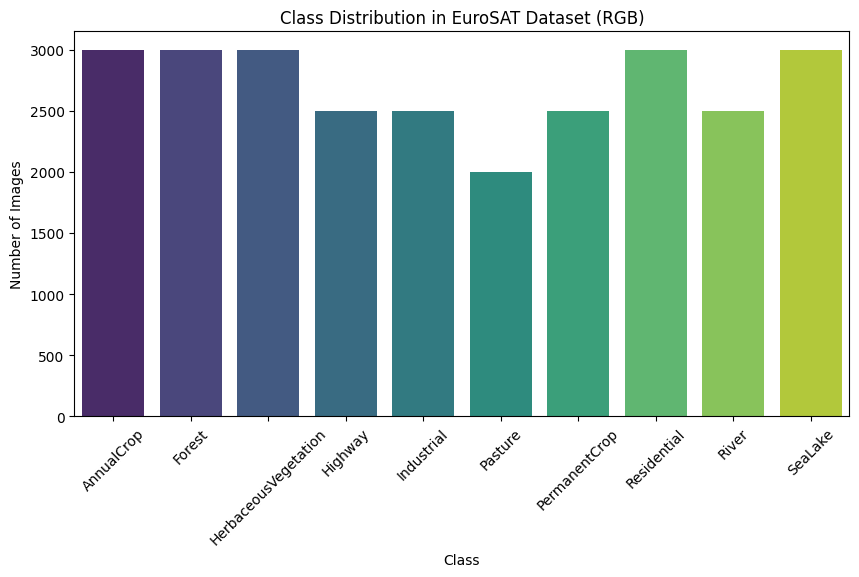

In [4]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset (RGB)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


# Check image shape & channels

Sample image: EuroSAT_RGB\SeaLake\SeaLake_2789.jpg
Shape: (64, 64, 3)


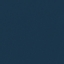

In [5]:


sample_class = random.choice(classes)
sample_path = os.path.join(DATA_DIR, sample_class, random.choice(os.listdir(os.path.join(DATA_DIR, sample_class))))

img = Image.open(sample_path)
img_array = np.array(img)

print("Sample image:", sample_path)
print("Shape:", img_array.shape)  
img


# Sample images grid

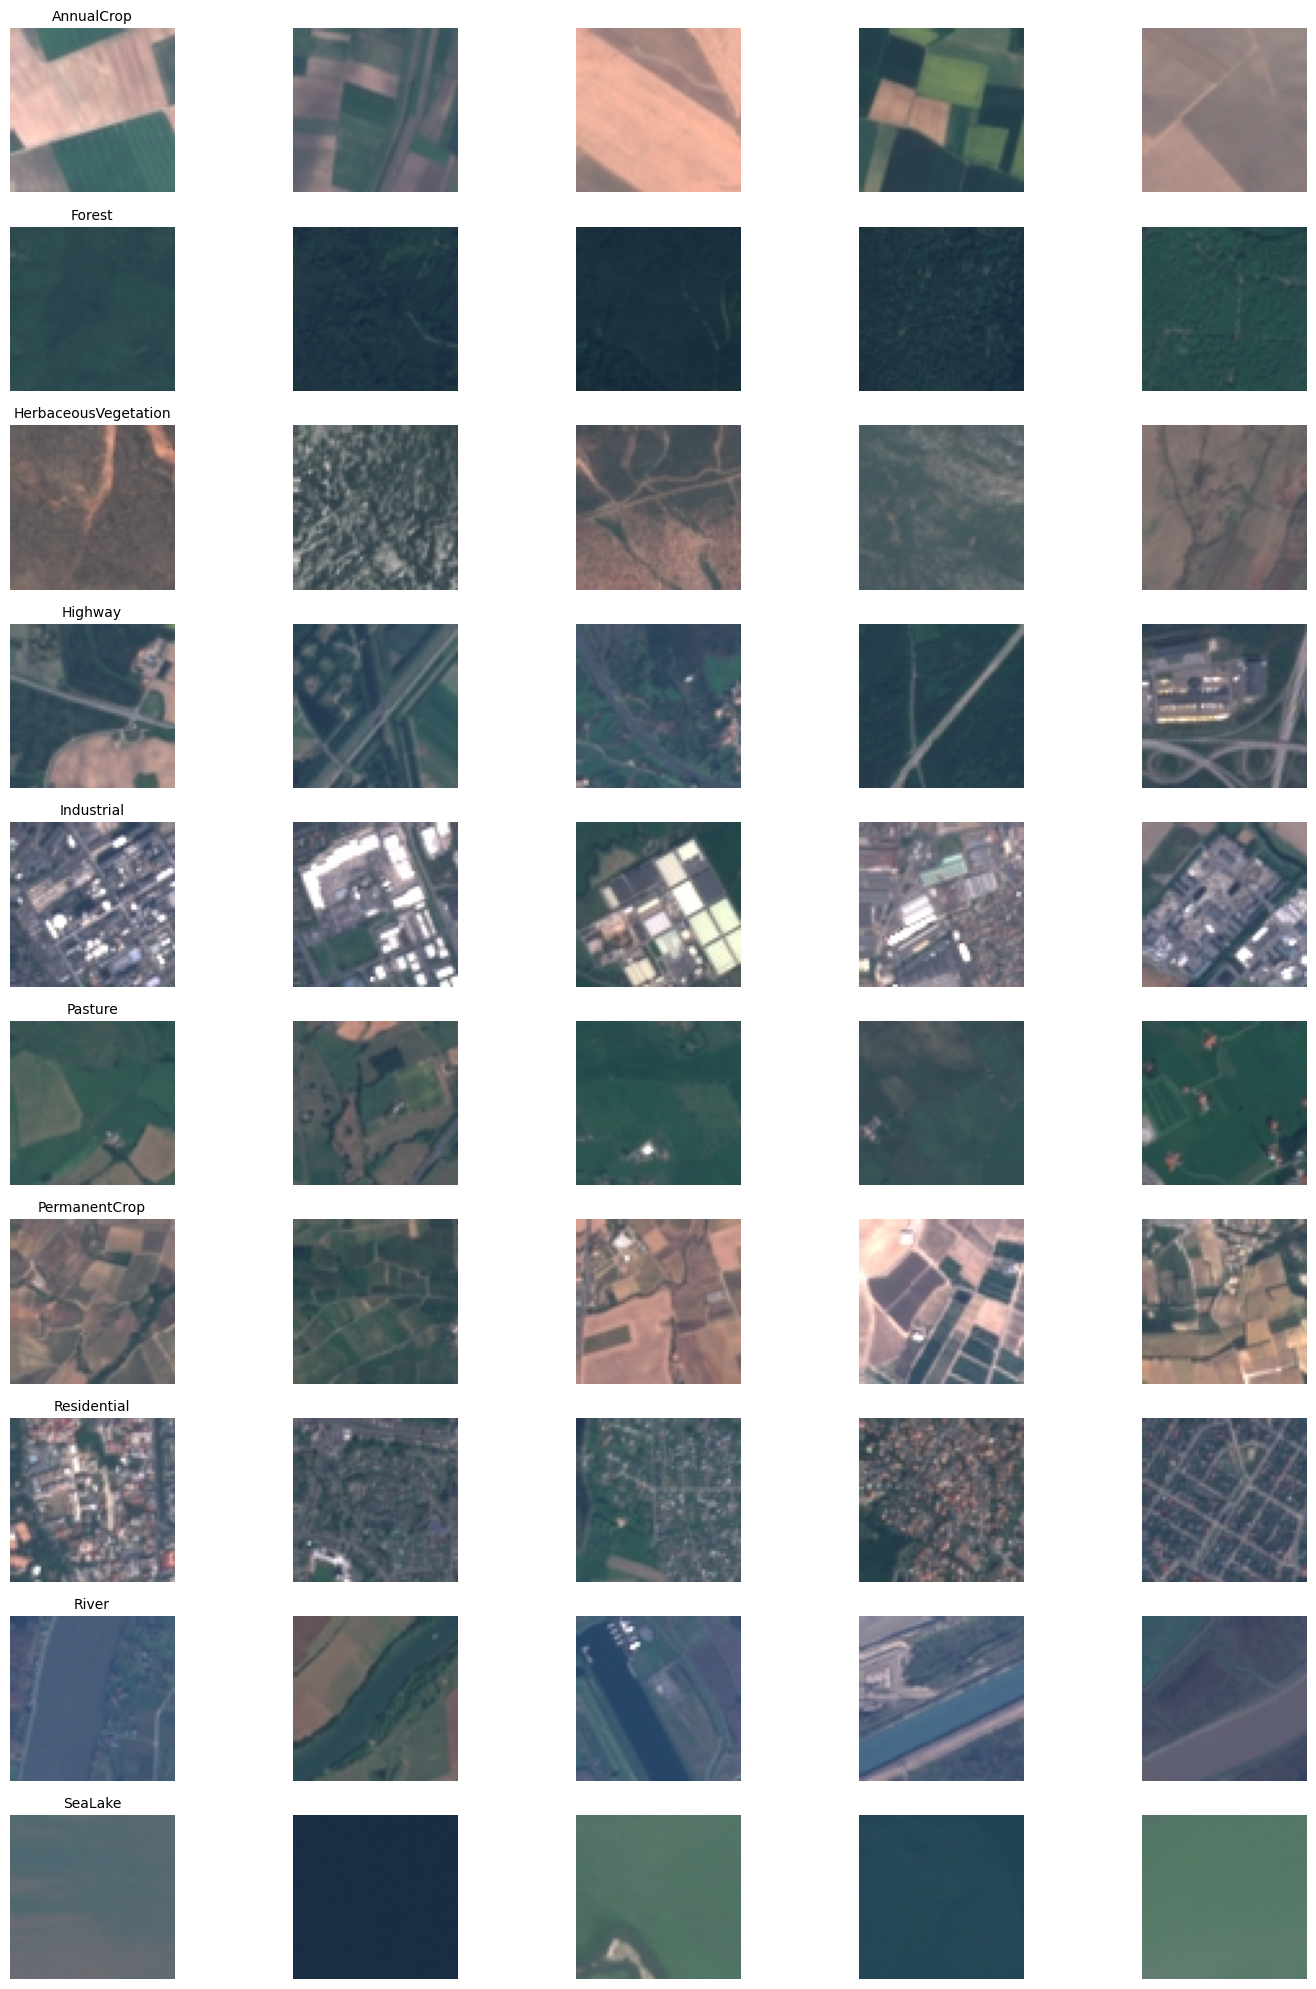

In [6]:
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 20))

for i, cls in enumerate(classes):
    cls_path = os.path.join(DATA_DIR, cls)
    samples = random.sample(os.listdir(cls_path), 5)
    
    for j, img_name in enumerate(samples):
        img_path = os.path.join(cls_path, img_name)
        img = np.array(Image.open(img_path))
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


# Pixel intensity statistics

In [7]:
mean_vals = []
std_vals = []

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    imgs = os.listdir(cls_path)[:200]  # limit for speed
    
    for img_name in imgs:
        img = np.array(Image.open(os.path.join(cls_path, img_name)))
        mean_vals.append(img.mean(axis=(0,1)))
        std_vals.append(img.std(axis=(0,1)))

mean_vals = np.array(mean_vals)
std_vals = np.array(std_vals)



import pandas as pd

df_stats = pd.DataFrame({
    "Channel": ["Red", "Green", "Blue"],
    "Mean Intensity": mean_vals.mean(axis=0),
    "Std Intensity": std_vals.mean(axis=0)
})

styled(df_stats)



,Channel,Mean Intensity,Std Intensity
0,Red,87.183513,23.480265
1,Green,96.733883,16.818471
2,Blue,103.535368,14.268289


# Pixel histograms

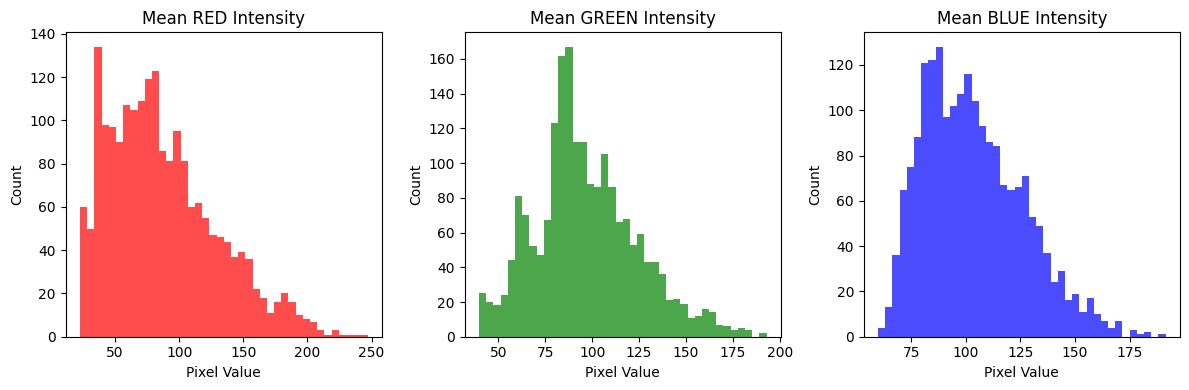

In [8]:
plt.figure(figsize=(12,4))
colors = ['red', 'green', 'blue']

for i, col in enumerate(colors):
    plt.subplot(1, 3, i+1)
    plt.hist(mean_vals[:, i], bins=40, color=col, alpha=0.7)
    plt.title(f"Mean {col.upper()} Intensity")
    plt.xlabel("Pixel Value")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


# Vegetation proxy (Green / (Red + Blue)) per class

In [9]:
veg_scores = {}

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    imgs = os.listdir(cls_path)[:150]
    
    scores = []
    for img_name in imgs:
        img = np.array(Image.open(os.path.join(cls_path, img_name)))
        R = img[:,:,0].astype(float)
        G = img[:,:,1].astype(float)
        B = img[:,:,2].astype(float)
        
        score = G / (R + B + 1e-6)
        scores.append(score.mean())
    
    veg_scores[cls] = np.mean(scores)

veg_scores

import pandas as pd

df_veg = pd.DataFrame({
    "Class": list(veg_scores.keys()),
    "Vegetation Proxy Score (G / (R + B))": list(veg_scores.values())
})


df_veg = df_veg.sort_values(by="Vegetation Proxy Score (G / (R + B))", ascending=False).reset_index(drop=True)

styled(df_veg)



,Class,Vegetation Proxy Score (G / (R + B))
0,Pasture,0.580174
1,Forest,0.560609
2,River,0.537155
3,SeaLake,0.520791
4,Highway,0.516590
5,AnnualCrop,0.501566
6,PermanentCrop,0.499961
7,HerbaceousVegetation,0.492526
8,Industrial,0.492371
9,Residential,0.491797


# Red Proxy Score Code (R / (G + B))

In [10]:
red_scores = {}

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    imgs = os.listdir(cls_path)[:150]
    
    scores = []
    for img_name in imgs:
        img = np.array(Image.open(os.path.join(cls_path, img_name)))
        R = img[:,:,0].astype(float)
        G = img[:,:,1].astype(float)
        B = img[:,:,2].astype(float)
        
        score = R / (G + B + 1e-6)
        scores.append(score.mean())
    
    red_scores[cls] = np.mean(scores)

# Create DataFrame
df_red = pd.DataFrame({
    "Class": list(red_scores.keys()),
    "Red Proxy Score (R / (G + B))": list(red_scores.values())
})

df_red = df_red.sort_values(
    by="Red Proxy Score (R / (G + B))", ascending=False
).reset_index(drop=True)

styled(df_red)


,Class,Red Proxy Score (R / (G + B))
0,AnnualCrop,0.518927
1,PermanentCrop,0.507558
2,HerbaceousVegetation,0.475071
3,Industrial,0.458286
4,Residential,0.443852
5,Highway,0.421500
6,River,0.344320
7,Pasture,0.340892
8,Forest,0.276359
9,SeaLake,0.274625


# Blue Proxy Score Code (B / (R + G))

In [11]:
blue_scores = {}

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    imgs = os.listdir(cls_path)[:150]

    scores = []
    for img_name in imgs:
        img = np.array(Image.open(os.path.join(cls_path, img_name)))
        R = img[:,:,0].astype(float)
        G = img[:,:,1].astype(float)
        B = img[:,:,2].astype(float)

        score = B / (R + G + 1e-6)
        scores.append(score.mean())

    blue_scores[cls] = np.mean(scores)

# Create DataFrame
df_blue = pd.DataFrame({
    "Class": list(blue_scores.keys()),
    "Blue Proxy Score (B / (R + G))": list(blue_scores.values())
})

df_blue = df_blue.sort_values(
    by="Blue Proxy Score (B / (R + G))", ascending=False
).reset_index(drop=True)

styled(df_blue)


,Class,Blue Proxy Score (B / (R + G))
0,SeaLake,0.823073
1,Forest,0.743906
2,River,0.668884
3,Pasture,0.621045
4,Highway,0.590649
5,Residential,0.578973
6,Industrial,0.562056
7,HerbaceousVegetation,0.546992
8,PermanentCrop,0.504504
9,AnnualCrop,0.502624


# Confusing class pairs preview

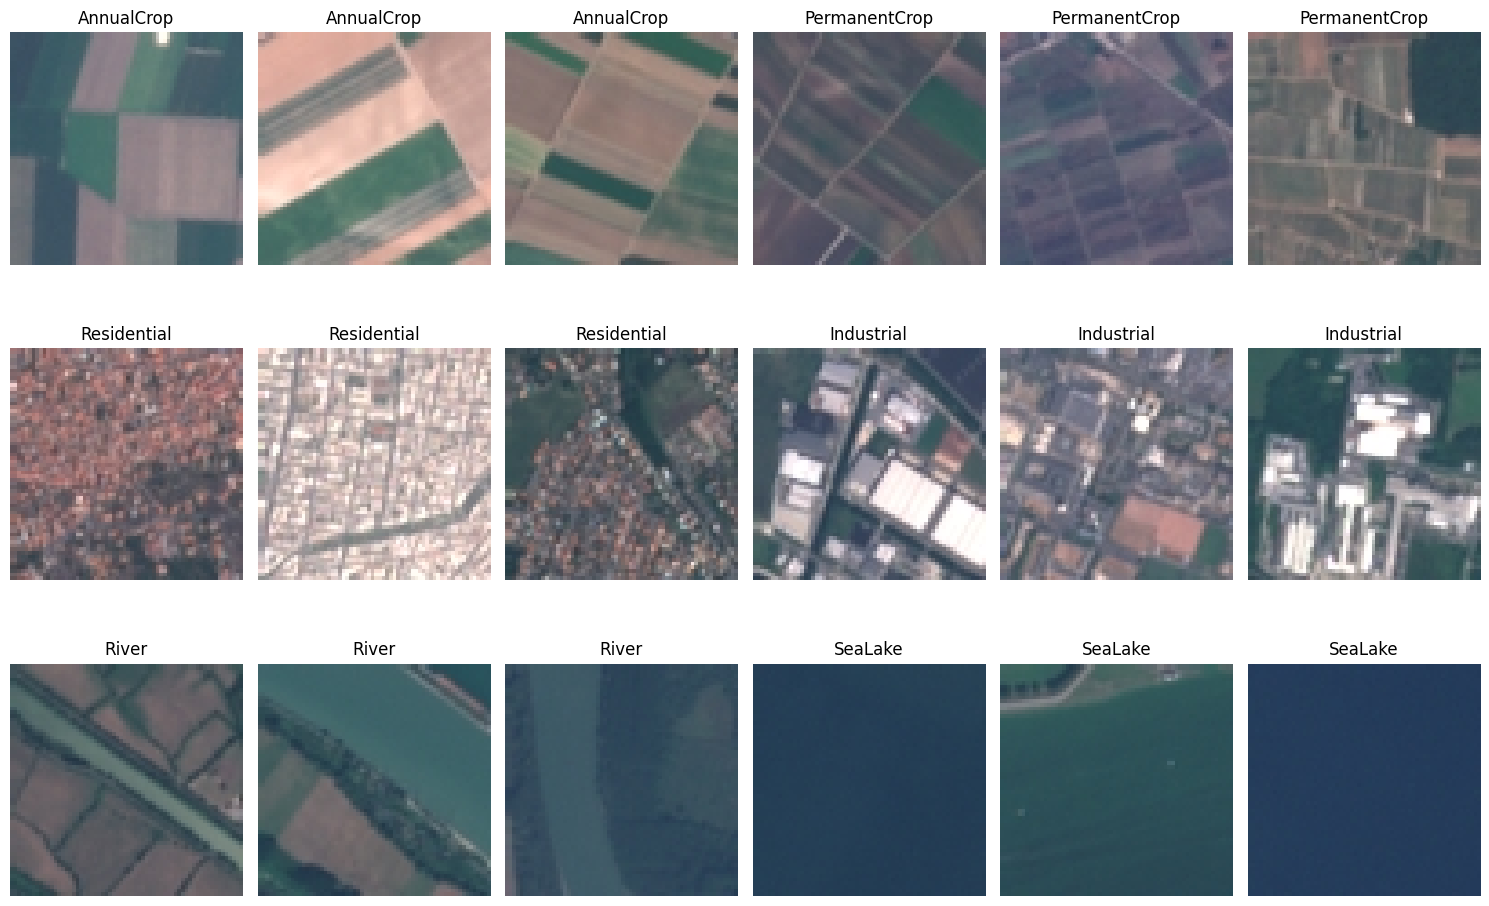

In [12]:
confusing_pairs = [
    ("AnnualCrop", "PermanentCrop"),
    ("Residential", "Industrial"),
    ("River", "SeaLake")
]

fig, axes = plt.subplots(len(confusing_pairs), 6, figsize=(15, 10))

for row, (c1, c2) in enumerate(confusing_pairs):
    imgs1 = random.sample(os.listdir(os.path.join(DATA_DIR, c1)), 3)
    imgs2 = random.sample(os.listdir(os.path.join(DATA_DIR, c2)), 3)

    # Show samples of class 1
    for col in range(3):
        img = Image.open(os.path.join(DATA_DIR, c1, imgs1[col]))
        axes[row, col].imshow(img)
        axes[row, col].set_title(c1)
        axes[row, col].axis("off")

    # Show samples of class 2
    for col in range(3):
        img = Image.open(os.path.join(DATA_DIR, c2, imgs2[col]))
        axes[row, col+3].imshow(img)
        axes[row, col+3].set_title(c2)
        axes[row, col+3].axis("off")

plt.tight_layout()
plt.show()
